In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
!cd $HOME/git/camb; git pull github CAMB_python; git log -1
import os
from matplotlib import pyplot as plt
import sys
import numpy as np
sys.path.insert(0,'/global/homes/a/aml1005/git/camb/pycamb')
import camb
from camb import model,initialpower

remote: Counting objects: 5, done.
remote: Compressing objects: 100% (5/5), done.
remote: Total 5 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (5/5), done.
From github.com:cmbant/CAMB
 * branch            CAMB_python -> FETCH_HEAD
Updating 3278973..c7c4d90
Fast-forward
 pycamb/camb/__init__.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)
commit c7c4d902653b2f645eab5cc26660c5b42539969a
Author: Antony Lewis <antony@cosmologist>
Date:   Wed Nov 18 14:38:52 2015 +0000

    docs


In [2]:
#Set up a new set of parameters for CAMB
pars = camb.CAMBparams()
#This function sets up CosmoMC-like settings, with one massive neutrino and helium set using BBN consistency
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, mnu=0.06, omk=0, tau=0.06)
pars.InitPower.set_params(ns=0.965, r=0)
pars.set_for_lmax(2500, lens_potential_accuracy=0);

In [3]:
#calculate results for these parameters
results = camb.get_results(pars)

In [4]:
#get dictionary of CAMB power spectra
powers =results.get_cmb_power_spectra(pars)
for name in powers: print name

total
lens_potential
lensed_scalar
unlensed_scalar
unlensed_total
tensor


(2551, 4)


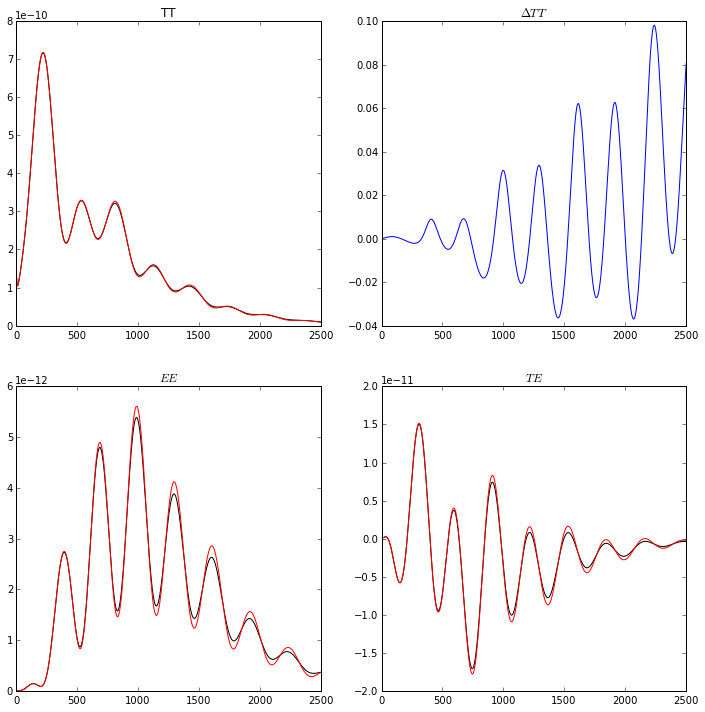

In [5]:
#plot the total lensed CMB power spectra versus unlensed, and fractional difference
totCL=powers['total']
unlensedCL=powers['unlensed_scalar']
print totCL.shape
#Python CL arrays are all zero based (starting at L=0), Note L=0,1 entries will be zero by default.
#The differenent CL are always in the order TT, EE, BB, TE (with BB=0 for unlensed scalar results).
ls = np.arange(totCL.shape[0])
fig, ax = plt.subplots(2,2, figsize = (12,12))
ax[0,0].plot(ls,totCL[:,0], color='k')
ax[0,0].plot(ls,unlensedCL[:,0], color='r')
ax[0,0].set_title('TT')
ax[0,1].plot(ls[2:], 1-unlensedCL[2:,0]/totCL[2:,0]);
ax[0,1].set_title(r'$\Delta TT$')
ax[1,0].plot(ls,totCL[:,1], color='k')
ax[1,0].plot(ls,unlensedCL[:,1], color='r')
ax[1,0].set_title(r'$EE$')
ax[1,1].plot(ls,totCL[:,3], color='k')
ax[1,1].plot(ls,unlensedCL[:,3], color='r')
ax[1,1].set_title(r'$TE$');
for ax in ax.reshape(-1): ax.set_xlim([2,2500])


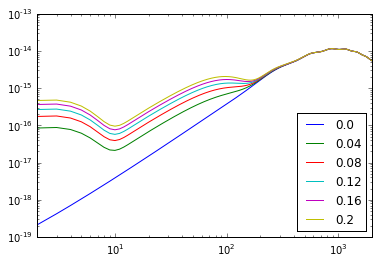

In [6]:
#You can calculate spectra for different primordial power spectra without recalculating everything
#for example, let's plot the BB spectra as a function of r
pars.WantTensors = True
results = camb.get_transfer_functions(pars)
lmax=2000
rs = np.linspace(0,0.2,6)
for r in rs:
    inflation_params = initialpower.InitialPowerParams()
    inflation_params.set_params(ns=0.96, r=r)
    results.power_spectra_from_transfer(inflation_params)
    cl = results.get_total_cls(lmax)
    plt.loglog(np.arange(lmax+1),cl[:,2])
plt.xlim([2,lmax])
plt.legend(rs, loc='lower right');

In [7]:
#Now get matter power spectra and sigma8 at redshift 0 and 0.8
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.set_dark_energy() #re-set defaults
pars.InitPower.set_params(ns=0.965)
#Not non-linear corrections couples to smaller scales than you want
pars.set_matter_power(redshifts=[0., 0.8], kmax=2.0)

#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)
s8 = np.array(results.get_sigma8())

#Non-Linear spectra (Halofit)
pars.NonLinear = model.NonLinear_both
results.calc_power_spectra(pars)
kh_nonlin, z_nonlin, pk_nonlin = results.get_matter_power_spectrum(minkh=1e-4, maxkh=1, npoints = 200)


Note: redshifts have been re-sorted (earliest first)


In [8]:
print results.get_sigma8()

[ 0.53308555  0.802653  ]


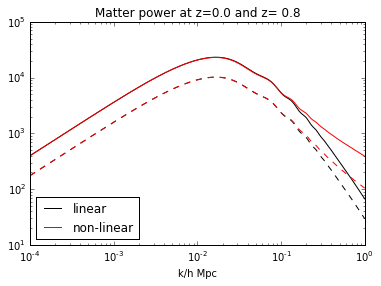

In [9]:
for i, (redshift, line) in enumerate(zip(z,['-','--'])):
    plt.loglog(kh, pk[i,:], color='k', ls = line)
    plt.loglog(kh_nonlin, pk_nonlin[i,:], color='r', ls = line)
plt.xlabel('k/h Mpc');
plt.legend(['linear','non-linear'], loc='lower left');
plt.title('Matter power at z=%s and z= %s'%tuple(z));

(2, 2000)

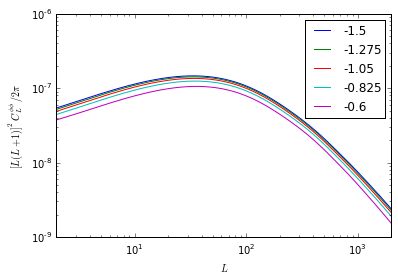

In [10]:
#Plot CMB lensing potential power for various values of w
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(As=2e-9, ns=0.965)
pars.set_for_lmax(2000, lens_potential_accuracy=1)

ws = np.linspace(-1.5, -0.6, 5)
for w in ws:
    pars.set_dark_energy(w) 
    results = camb.get_results(pars)
    cl = results.get_lens_potential_cls(lmax=2000)
    plt.loglog(np.arange(2001), cl[:,0])

#Note dark energy model is currently global, so reset to LCDM by using this:
pars.set_dark_energy() 
plt.legend(ws)
plt.ylabel('$[L(L+1)]^2C_L^{\phi\phi}/2\pi$')
plt.xlabel('$L$')
plt.xlim([2,2000])


In [11]:
#You can view the parameters (as used by fortran CAMB) using print. 
#Note some of these (from ReionHist) are not input parameters but calculated
print pars

WantCls = 1
WantTransfer = 0
WantScalars = 1
WantTensors = 0
WantVectors = 0
DoLensing = 1
want_zstar = 0
want_zdrag = 0
PK_WantTransfer = 0
NonLinear = 2
Want_CMB = 1
max_l = 2150
max_l_tensor = 600
max_eta_k = 18000.0
max_eta_k_tensor = 1200.0
omegab = 0.0482853223594
omegac = 0.267764060357
omegav = 0.682534663613
omegan = 0.00141595367142
H0 = 67.5
TCMB = 2.7255
YHe = 0.245223829794
num_nu_massless = 2.03066666667
num_nu_massive = 1
nu_mass_eigenstates = 1
share_delta_neff = 0
nu_mass_degeneracies = [1.0153333333333332, 0.0, 0.0, 0.0, 0.0]
nu_mass_fractions = [1.0, 0.0, 0.0, 0.0, 0.0]
nu_mass_numbers = [1, 0, 0, 0, 0]
scalar_initial_condition = 1
OutputNormalization = 1
AccuratePolarization = 1
AccurateBB = 0
AccurateReionization = 0
MassiveNuMethod = 3
InitPower:
  tensor_parameterization = 2
  nn = 1
  an = [0.965, 1.0, 1.0, 1.0, 1.0]
  n_run = [0.0, 0.0, 0.0, 0.0, 0.0]
  n_runrun = [0.0, 0.0, 0.0, 0.0, 0.0]
  ant = [0.0, 0.0, 0.0, 0.0, 0.0]
  nt_run = [-0.0, 0.0, 0.0, 0.0, 0.0]


In [12]:
#You can also get various background functions and derived parameters
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
results = camb.get_background(pars)
print 'Derived parameter dictionary:\n', results.get_derived_params()

Derived parameter dictionary:
{'rdrag': 146.97861407805524, 'rstar': 144.19779935407806, 'age': 13.740500129586403, 'kd': 0.14070568081533663, 'zdrag': 1059.2079162597656, 'thetaeq': 0.808068668115522, 'zstar': 1090.5838012695312, 'thetarseq': 0.44700129353905566, 'zeq': 3441.168556293452, 'thetad': 0.16173834228683662, 'thetastar': 1.0445599715721987, 'keq': 0.010502751815052997, 'DAstar': 13.804645331856017}


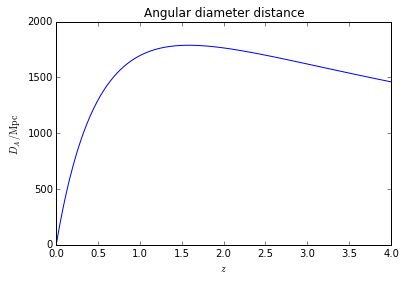

In [13]:
z = np.linspace(0,4,100)
DA = results.angular_diameter_distance(z)
plt.plot(z, DA)
plt.xlabel('$z$')
plt.ylabel(r'$D_A /\rm{Mpc}$')
plt.title('Angular diameter distance')
plt.ylim([0,2000]);

In [14]:
print 'CosmoMC theta_MC parameter: ', results.cosmomc_theta()

CosmoMC theta_MC parameter:  0.01044349756
